In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import sys
import time
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import fbprophet as fp
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics

In [2]:
pd.set_option('display.max_columns', 400)

In [3]:
# ścieżka do plików z danymi
path = "dane"

In [4]:
def AUC(cl, X, Y):
    fpr, tpr, _ = roc_curve(Y, cl.predict_proba(X)[:, 1])
    return auc(fpr, tpr)

gbd_names = np.array([pd.to_datetime(f.split('.')[0]).date() for f in listdir(path) if isfile("%s/%s" % (path, f))])
gbd_names = np.sort(gbd_names)

def read_precomputed_data(dts, data_path=lambda dt: '%s/%s.h5' % (path, dt)):
    all_data = pd.read_hdf(data_path(dts[0]), 'data')
    
    for dt in dts[1:]:
        data = pd.read_hdf(data_path(dt), 'data')
        all_data = pd.concat([all_data, data])
        
    return all_data



fe = lambda s: ['%s_%s' % (i, s) for i in range(10)]

base_features = ['imbalance', 'mid_price', 'mid_price_diff', 'is_positive_mid_diff',\
                 'is_negative_mid_diff', 'is_neutral_mid_diff','incs', 'decs',\
                 'nochanges', 'cnt', '10_bids_mean_volume', '10_asks_mean_volume',\
                 '10_bids_sum_volume', '10_asks_sum_volume', 'time_to_int',\
                 'total_bids_volume_gain', 'total_asks_volume_gain',\
                 'total_volumes_dist_gain', 'mid_price_gain', 'price_impact'] \
                 + fe('bid_price_gain') + fe('ask_price_gain') \
                 + fe('bid_price') + fe('bid_volume') + fe('ask_price') \
                 + fe('ask_volume') + fe('bid_price_diff') \
                 + fe('ask_price_diff') + fe('bid_volume_diff') \
                 + fe('ask_volume_diff') + fe('price_spread')

In [5]:
def prepare_data(days_for_prophet, days_for_classifier, days_for_test,\
                 weekdays, time_constraint=[540,960]):

    days_num = days_for_prophet + days_for_classifier + days_for_test
    chosen_first_day_ind = np.random.randint(len(gbd_names[:-days_num+1]))
    chosen_days = gbd_names[chosen_first_day_ind:chosen_first_day_ind+days_num]
    chosen_days = np.sort(chosen_days)
    
    non_prophet_days = days_for_classifier + days_for_test
    
    prophet_data = read_precomputed_data(chosen_days[:-non_prophet_days])
    prophet_data = prophet_data[prophet_data.date.dt.weekday.isin(weekdays)]
    prophet_data = prophet_data[prophet_data.time_to_int\
                                .between(time_constraint[0], time_constraint[1])]
    
    classifier_data = read_precomputed_data(chosen_days[-non_prophet_days:-days_for_test])
    classifier_data = classifier_data[classifier_data.date.dt.weekday.isin(weekdays)]
    classifier_data = classifier_data[classifier_data.time_to_int\
                                      .between(time_constraint[0], time_constraint[1])]
    
    test_data = read_precomputed_data(chosen_days[-days_for_test:])
    test_data = test_data[test_data.date.dt.weekday.isin(weekdays)]
    test_data = test_data[test_data.time_to_int\
                          .between(time_constraint[0], time_constraint[1])]
    
    return prophet_data, classifier_data, test_data

In [6]:
# capacitance jest ograniczeniem z góry, koniecznym gdy trend w prophecie modelowany jest logistycznie

def compute_capacitances(data, feature):
    caps = dict()
    for stock_name in data.stock_name.unique():
        caps[stock_name] = data[data.stock_name == stock_name][feature].max() * 1.15
    return caps

In [7]:
def adjust_forecasted_data_for_prophet(data, caps, forecasted_feature='mid_price'):
    adj_data = data.drop('y', axis=1).copy()
    adj_data['cap'] = 0.
    for stock_name in data.stock_name.unique():
        adj_data.cap[adj_data.stock_name == stock_name] = caps[stock_name]
    adj_data = adj_data.rename(columns={'date': 'ds', forecasted_feature: 'y'})
    return adj_data[['ds', 'y', 'cap', 'stock_name']]

In [8]:
def make_forecast_for_stocks(prophet_data, classifier_data, test_data, stock_names,\
                             prophet_constructor, stride=1):
    
    classifier_train_data_forecasts = dict()
    classifier_test_data_forecasts = dict()
    
    for current_stock_name in stock_names:
        print('Debug: Making forecast for ' + str(current_stock_name)[:-2])
        
        stock_prophet_data = prophet_data[prophet_data.stock_name == current_stock_name]
        stock_classifier_data = classifier_data[classifier_data.stock_name\
                                                == current_stock_name]
        stock_test_data = test_data[test_data.stock_name == current_stock_name]

        if stock_prophet_data.shape[0] * stock_classifier_data.shape[0]\
            * stock_test_data.shape[0] == 0:
            
            continue
        
        
        m = prophet_constructor()
        m = m.fit(stock_prophet_data[::stride])

        classifier_train_data_forecasts[current_stock_name] =\
            m.predict(stock_classifier_data)

        m_test = prophet_constructor()
        m_test = m_test.fit(stock_prophet_data[::stride]\
                            .append(stock_classifier_data[::stride]))
        
        classifier_test_data_forecasts[current_stock_name] =\
            m_test.predict(stock_classifier_data)
        
    return classifier_train_data_forecasts, classifier_test_data_forecasts

In [9]:
# tworzenie podtablicy w ten sposób, że zawsze ma taką samą długość

def get_subarr(arr, i, j):
    if j <= arr.shape[0]:
        return arr[i:j]
    return np.array(list(arr[i:]) + [0.]*(j-arr.shape[0]))

def get_subarr_inv(arr, i, j):
    if j >= 0:
        return arr[i:j:-1]
    return np.array(list(arr[i::-1]) + [0.]*(-j-1))

In [10]:
# wyliczanie średnich z danych uczących, aby poźniej na podstawie nich normalizować
#   wartości predykcji propheta

def compute_mean_for_each_stock(data, feature):
    means = dict()
    for stock_name in data.stock_name.unique():
        means[stock_name] = data[data.stock_name == stock_name][feature].mean()
    return means

In [11]:
def construct_samples_with_forecast(X, fcst, past_stock_mean):
    extended_X = X.copy()
    
    # tworzenie parametrów na podstawie prognozy z propheta
    
    k = 12
    
    fcst = fcst[:len(X)]
    fcst_norm = fcst.yhat.values / past_stock_mean
    diffs = np.hstack((fcst_norm[1:] - fcst_norm[:-1], [0.]))
    
    frames_of_succeeding_diffs = [get_subarr(diffs, i, i+k) for i in range(len(fcst))]
    frames_of_preceding_diffs = [get_subarr_inv(diffs, i, i-k) for i in range(len(fcst))]
    
    frames_of_succeeding_diffs = np.array(frames_of_succeeding_diffs)
    frames_of_preceding_diffs = np.array(frames_of_preceding_diffs)

    future_growth = frames_of_succeeding_diffs.sum(1)
    past_growth = frames_of_preceding_diffs.sum(1)
    
    future_growth_speed = frames_of_succeeding_diffs.mean(1)
    past_growth_speed = frames_of_preceding_diffs.mean(1)
    
    future_growth_max = frames_of_succeeding_diffs.max(1)
    past_growth_max = frames_of_preceding_diffs.max(1)
    
    future_growth_min = frames_of_succeeding_diffs.min(1)
    past_growth_min = frames_of_preceding_diffs.min(1)
    
    diff_to_end = fcst_norm - fcst_norm[-1]
    diff_to_begin = fcst_norm - fcst_norm[0]

    extended_X = np.c_[extended_X, frames_of_preceding_diffs, frames_of_succeeding_diffs,
                       future_growth, past_growth,
                       diff_to_end, diff_to_begin,
                       future_growth_speed, past_growth_speed,
                       future_growth_max, past_growth_max,
                       future_growth_min, past_growth_min]

    return extended_X


def construct_XY_sets(data, forecasts, means, features):
    X, no_prophet_X, Y, samples_stock_names = [], [], [], []
    stock_names = data.stock_name.unique()
    
    for stock_name in stock_names:
        stock_data = data[data.stock_name == stock_name]
        base_X = stock_data[features]
        no_prophet_X += base_X.values.tolist()
        Y += stock_data.y.values.tolist()
        
        fcst = forecasts[stock_name]
        mean = means[stock_name]
        X += construct_samples_with_forecast(base_X, fcst, mean).tolist()
        samples_stock_names += stock_data.stock_name.values.tolist()
        
    X, no_prophet_X = np.array(X), np.array(no_prophet_X)
    Y, samples_stock_names = np.array(Y), np.array(samples_stock_names)
    return X, no_prophet_X, Y, samples_stock_names

In [12]:
def construct_and_test_model(train_data, test_data, train_forecasts, test_forecasts,\
                             train_means, test_means, features):
    
    X, no_prophet_X, Y, _ =\
        construct_XY_sets(train_data, train_forecasts, train_means, features)
    
    Xtest, no_prophet_Xtest, Ytest, test_samples_stock_names =\
        construct_XY_sets(test_data, test_forecasts, test_means, features)

    results = []    
    classifier_train_samples_limit = 100000

    prophet_cl = xgb.XGBClassifier()
    prophet_cl = prophet_cl.fit(X[-classifier_train_samples_limit:],\
                                Y[-classifier_train_samples_limit:])

    no_prophet_cl = xgb.XGBClassifier()
    no_prophet_cl = no_prophet_cl.fit(no_prophet_X[-classifier_train_samples_limit:],\
                                      Y[-classifier_train_samples_limit:])


    for stock_name in np.unique(test_samples_stock_names):

        stock_inds = test_samples_stock_names == stock_name
        stock_Xtest = Xtest[stock_inds]
        stock_no_prophet_Xtest = no_prophet_Xtest[stock_inds]
        stock_Ytest = Ytest[stock_inds]

        value_with_prophet = AUC(prophet_cl, stock_Xtest, stock_Ytest)
        value_without_prophet = AUC(no_prophet_cl, stock_no_prophet_Xtest, stock_Ytest)

        results.append([str(stock_name)[:-2], value_with_prophet, value_without_prophet])
            
    results = pd.DataFrame(results, columns=['stock', 'AUC with prophet',\
                                             'AUC without prophet'])
    return results

## Sceniariusz 1:
- Brane są pod uwagę wszystkie z około 100 spółek.
- Brane są pod uwagę tylko czwartki.
- Trend w modelu propheta modelowany jest logistycznie.

In [13]:
# wczytanie danych LOB
# podział na 3 zbiory: jeden do zbudowania modelu propheta
#   drugi zbiór do uczenia klasyfikatora (na danych LOB; czy mid-price wzrośnie)
#     i również bierze udział w tworzeniu modelu propheta dla predykcji danych testowych
#   trzeci zbiór do testowania klasyfikatora


# jako parametr 'weekday' można wskazać konkretne dni tygodnia; [0,1,2,3,4] to pon.-pt.

prophet_data, classifier_data, test_data = \
    prepare_data(days_for_prophet=30, days_for_classifier= 20,\
                 days_for_test=5, weekdays=[3], time_constraint=[540, 960])

In [14]:
prophet_data.head()

dir_name  stock_name                date  time_to_int  day_id  \
record_id                                                                  
1264        10901.0     10166.0 2013-09-05 09:01:00        541.0     0.0   
1265        10901.0     10166.0 2013-09-05 09:02:00        542.0     0.0   
1266        10901.0     10166.0 2013-09-05 09:03:00        543.0     0.0   
1267        10901.0     10166.0 2013-09-05 09:04:00        544.0     0.0   
1268        10901.0     10166.0 2013-09-05 09:05:00        545.0     0.0   

           mid_price  nochanges  cnt      incs  is_positive_mid_diff  \
record_id                                                              
1264         3086.50   0.000000  1.0  0.000000                   0.0   
1265         3087.50   0.000000  2.0  0.500000                   1.0   
1266         3087.50   0.333333  3.0  0.333333                   0.0   
1267         3087.75   0.250000  4.0  0.500000                   1.0   
1268         3087.50   0.200000  5.0  0.400000                   0.0   

           is_neutral_mid_diff  is_negative_mid_diff      decs    y  \
record_id                                                             
1264                       0.0                   1.0  1.000000  1.0   
1265                       0.0                   0.0  0.500000  0.0   
1266                       1.0                   0.0  0.333333  1.0   
1267                       0.0                   0.0  0.250000  0.0   
1268                       0.0                   1.0  0.400000  1.0   

           imbalance  10_bids_mean_volume  10_asks_mean_volume  \
record_id                                                        
1264       -0.440448               2832.9               2686.5   
1265       -0.431818               2850.5               2820.7   
1266       -0.595376               2674.6               3161.9   
1267        0.243792               2695.9               2655.0   
1268       -0.526196               2710.9               2400.9   

           10_bids_sum_volume  10_asks_sum_volume  0_bid_price_diff  \
record_id                                                             
1264                  28329.0             26865.0              -1.0   
1265                  28505.0             28207.0               1.0   
1266                  26746.0             31619.0               0.0   
1267                  26959.0             26550.0               0.5   
1268                  27109.0             24009.0               0.0   

           0_bid_price  0_price_spread  0_bid_price_gain  0_bid_volume  \
record_id                                                                
1264            3085.5             2.0              -1.0         901.0   
1265            3086.5             2.0               0.0         882.0   
1266            3086.5             2.0               0.0        1380.0   
1267            3087.0             1.5               0.5         335.0   
1268            3087.0             1.0               0.5         335.0   

           0_ask_price_gain  0_ask_volume_diff  0_ask_volume  0_volume_spread  \
record_id                                                                       
1264                   -0.5              810.0         350.0           -551.0   
1265                    0.5              -19.0         350.0           -532.0   
1266                    0.5              498.0         350.0          -1030.0   
1267                    0.5            -1045.0         551.0            216.0   
1268                    0.0                0.0         104.0           -231.0   

           0_ask_price  0_bid_volume_diff  0_ask_price_diff  1_bid_price_gain  \
record_id                                                                       
1264            3087.5              810.0              -0.5              -1.0   
1265            3088.5              -19.0               1.0               0.0   
1266            3088.5              498.0               0.0               0.0   
1267            3088.5

In [15]:
# dostosowanie dataframów do propheta

feature_to_forecast = 'mid_price'

caps = compute_capacitances(prophet_data, feature_to_forecast)

adj_prophet_data =\
    adjust_forecasted_data_for_prophet(data=prophet_data, caps=caps,\
                                       forecasted_feature=feature_to_forecast)

adj_classifier_data =\
    adjust_forecasted_data_for_prophet(data=classifier_data, caps=caps,\
                                       forecasted_feature=feature_to_forecast)

pre_test_data = prophet_data.append(classifier_data)
test_caps = compute_capacitances(pre_test_data, feature_to_forecast)

adj_test_data =\
    adjust_forecasted_data_for_prophet(data=test_data, caps=test_caps,\
                                       forecasted_feature=feature_to_forecast)


classifier_train_data_means =\
    compute_mean_for_each_stock(data=prophet_data,feature=feature_to_forecast)

classifier_test_data_means =\
    compute_mean_for_each_stock(data=pre_test_data, feature=feature_to_forecast)

In [16]:
# tworzenie prognoz prophetem
# dla wielu spółek może zająć dużo czasu

prophet_model_constructor = lambda:fp.Prophet(changepoint_prior_scale=0.01, growth='logistic')

classifier_train_data_forecasts, classifier_test_data_forecasts =\
    make_forecast_for_stocks(prophet_data=adj_prophet_data,\
                             classifier_data=adj_classifier_data,\
                             test_data=adj_test_data,\
                             stock_names=prophet_data.stock_name.unique(),\
                             prophet_constructor=prophet_model_constructor,\
                             stride=1)

Debug: Making forecast for 10166
Debug: Making forecast for 10470
Debug: Making forecast for 10484
Debug: Making forecast for 10508
Debug: Making forecast for 10795
Debug: Making forecast for 1080
Debug: Making forecast for 10887
Debug: Making forecast for 11038
Debug: Making forecast for 1113
Debug: Making forecast for 11234
Debug: Making forecast for 11244
Debug: Making forecast for 11390
Debug: Making forecast for 11399
Debug: Making forecast for 11583
Debug: Making forecast for 11618
Debug: Making forecast for 11714
Debug: Making forecast for 11867
Debug: Making forecast for 11869
Debug: Making forecast for 11946
Debug: Making forecast for 12059
Debug: Making forecast for 12098
Debug: Making forecast for 1221
Debug: Making forecast for 12255
Debug: Making forecast for 1229
Debug: Making forecast for 12327
Debug: Making forecast for 12417
Debug: Making forecast for 1243
Debug: Making forecast for 12456
Debug: Making forecast for 12534
Debug: Making forecast for 12552
Debug: Making f

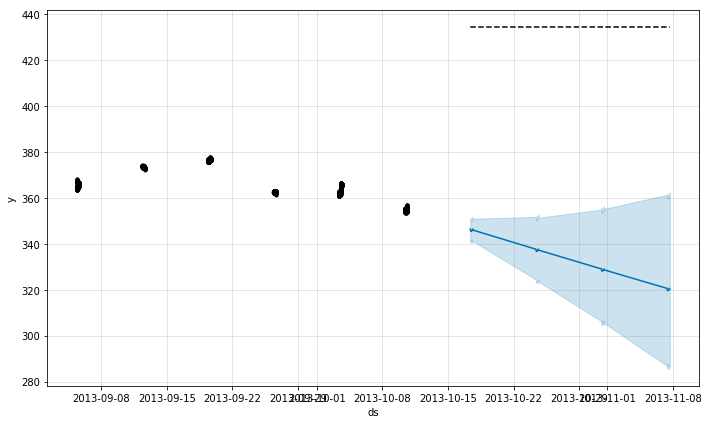

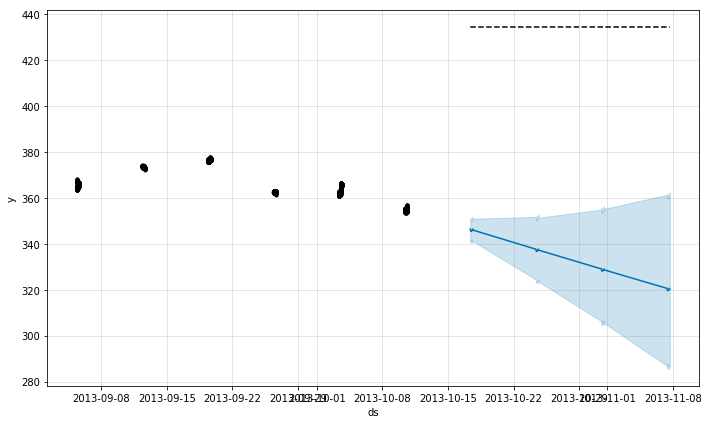

In [22]:
# przykładowy rysunek prognozy
# mało widać - próbki danych dla konkretnego dnia są mocno zbite, a prognoza
#   jest niesłusznie linią ciągłą

m = prophet_model_constructor()
rnd_stock_name = np.random.choice(adj_prophet_data.stock_name.unique(), 1)[0]
m.fit(adj_prophet_data[adj_prophet_data.stock_name == rnd_stock_name])
example_forecast = m.predict(adj_classifier_data[adj_classifier_data.stock_name\
                                                 == rnd_stock_name])
m.plot(example_forecast)

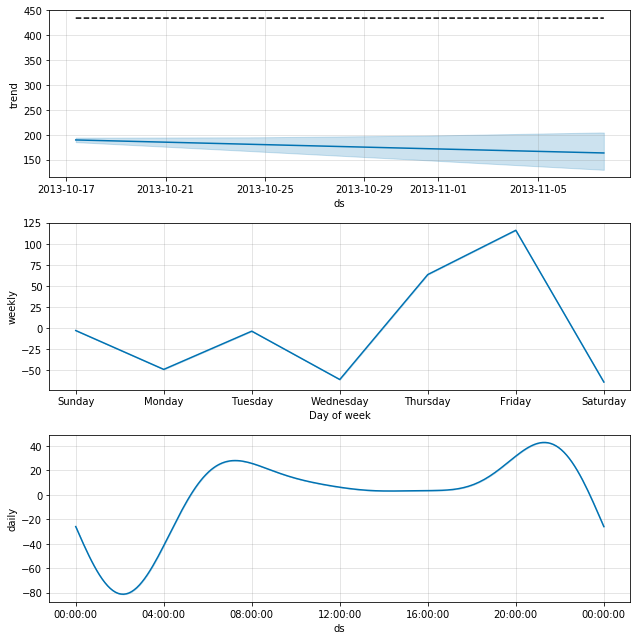

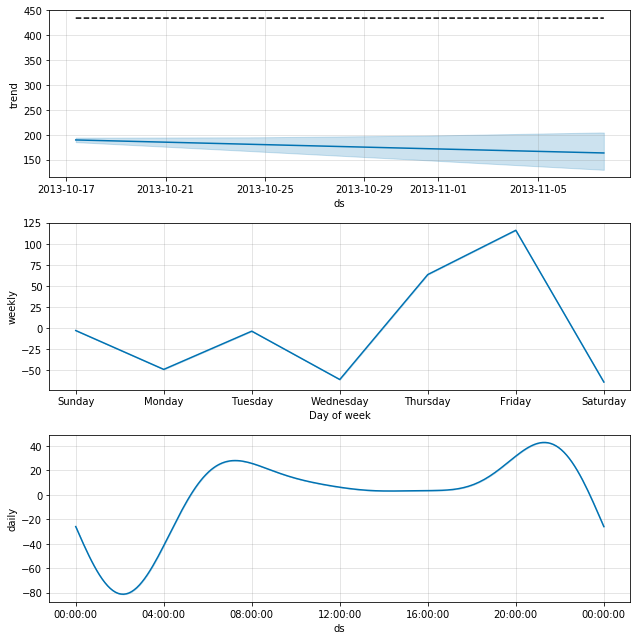

In [24]:
# składowe modelu
m.plot_components(example_forecast)

In [25]:
# scenariusz 1a: bazowo do predykcji LOB bierzemy dużo cech

results = construct_and_test_model(train_data=classifier_data,\
                                   test_data=test_data,\
                                   train_forecasts=classifier_train_data_forecasts,\
                                   test_forecasts=classifier_test_data_forecasts,\
                                   train_means=classifier_train_data_means,\
                                   test_means=classifier_test_data_means,\
                                   features=base_features)
results

stock  AUC with prophet  AUC without prophet
0    1080          0.666667             0.662791
1    1113          0.591171             0.585697
2    1221          0.613769             0.610774
3    1229          0.563061             0.560246
4    1243          0.597070             0.597605
5    1388          0.542997             0.541892
6    1431          0.614543             0.615970
7    1472          0.665235             0.665092
8    1694          0.695582             0.694169
9    1769          0.618136             0.620128
10   1865          0.628378             0.631099
11   1907          0.611300             0.613080
12   1956          0.618470             0.620377
13   2028          0.723281             0.714661
14   2050          0.543464             0.541270
15   2051          0.586676             0.586676
16   2057          0.574239             0.568314
17   2094          0.593671             0.600062
18   2197          0.742564             0.742744
19   2290          0.590659             0.588616
20   2368          0.632266             0.630837
21   2602          0.554259             0.551563
22   2645          0.589116             0.589620
23   2651          0.587354             0.581710
24   2730          0.699018             0.701227
25   2748          0.706586             0.700377
26   2813          0.673641             0.669523
27   2822          0.663964             0.661887
28   2890          0.672283             0.669241
29   3022          0.582222             0.588333
..    ...               ...                  ...
68   9761          0.642997             0.638625
69   9926          0.619032             0.616419
70  10166          0.630622             0.630865
71  10470          0.696949             0.700795
72  10484          0.589298             0.592977
73  10508          0.554612             0.549465
74  10795          0.697397             0.696895
75  10887          0.612775             0.614655
76  11038          0.631630             0.619693
77  11234          0.585350             0.586709
78  11244          0.620198             0.620948
79  11399          0.654038             0.657615
80  11583          0.640547             0.641948
81  11618          0.710244             0.736792
82  11714          0.614875             0.614004
83  11867          0.564923             0.581592
84  11869          0.637043             0.635490
85  11946          0.632241             0.633279
86  12059          0.614514             0.616514
87  12098          0.655480             0.653741
88  12255          0.698644             0.705192
89  12327          0.632617             0.633067
90  12417          0.665178             0.666009
91  12456          0.615526             0.607772
92  12534          0.668920             0.664173
93  12552          0.677694             0.684053
94  12713          0.647650             0.653465
95  13003          0.612297             0.613361
96  13061          0.674195             0.676644
97  13113          0.661514             0.664556

[98 rows x 3 columns]

In [26]:
results.mean()

stock                       inf
AUC with prophet       0.624332
AUC without prophet    0.624119
dtype: float64

In [27]:
# scenariusz 1b: bazowo do predykcji LOB bierzemy tylko imbalance

results = construct_and_test_model(train_data=classifier_data,\
                                   test_data=test_data,\
                                   train_forecasts=classifier_train_data_forecasts,\
                                   test_forecasts=classifier_test_data_forecasts,\
                                   train_means=classifier_train_data_means,\
                                   test_means=classifier_test_data_means,\
                                   features=['imbalance'])
results

stock  AUC with prophet  AUC without prophet
0    1080          0.649434             0.652664
1    1113          0.572511             0.566525
2    1221          0.619799             0.630869
3    1229          0.535752             0.537561
4    1243          0.604170             0.616649
5    1388          0.532328             0.536689
6    1431          0.641845             0.633928
7    1472          0.625483             0.609580
8    1694          0.650056             0.656663
9    1769          0.595154             0.586626
10   1865          0.598967             0.585586
11   1907          0.622647             0.634238
12   1956          0.564300             0.558140
13   2028          0.762327             0.740321
14   2050          0.535862             0.531630
15   2051          0.589415             0.590413
16   2057          0.567119             0.546252
17   2094          0.588364             0.591925
18   2197          0.683307             0.689839
19   2290          0.574327             0.576890
20   2368          0.638375             0.634183
21   2602          0.535863             0.538535
22   2645          0.548395             0.536593
23   2651          0.623197             0.616347
24   2730          0.654534             0.653306
25   2748          0.702885             0.699112
26   2813          0.646413             0.649082
27   2822          0.615552             0.596623
28   2890          0.623479             0.641980
29   3022          0.570038             0.565265
..    ...               ...                  ...
68   9761          0.638064             0.640106
69   9926          0.585852             0.579968
70  10166          0.633916             0.628847
71  10470          0.648930             0.644244
72  10484          0.588448             0.589967
73  10508          0.557495             0.541812
74  10795          0.635381             0.628281
75  10887          0.584541             0.604727
76  11038          0.586592             0.562976
77  11234          0.590599             0.586281
78  11244          0.607221             0.612482
79  11399          0.610434             0.642141
80  11583          0.637402             0.634392
81  11618          0.682032             0.713705
82  11714          0.606324             0.604852
83  11867          0.575263             0.572369
84  11869          0.624993             0.647253
85  11946          0.632724             0.601827
86  12059          0.608088             0.597896
87  12098          0.589094             0.594583
88  12255          0.657276             0.665021
89  12327          0.644094             0.648352
90  12417          0.628947             0.621780
91  12456          0.621965             0.607559
92  12534          0.636429             0.644110
93  12552          0.678961             0.669966
94  12713          0.618971             0.642384
95  13003          0.571064             0.568613
96  13061          0.659555             0.648323
97  13113          0.624601             0.606302

[98 rows x 3 columns]

In [28]:
results.mean()

stock                       inf
AUC with prophet       0.608554
AUC without prophet    0.607617
dtype: float64

In [29]:
# scenariusz 1c: bazowo do predykcji LOB bierzemy nieistotną cechę (sam mid-price nic nie wnosi)

results = construct_and_test_model(train_data=classifier_data,\
                                   test_data=test_data,\
                                   train_forecasts=classifier_train_data_forecasts,\
                                   test_forecasts=classifier_test_data_forecasts,\
                                   train_means=classifier_train_data_means,\
                                   test_means=classifier_test_data_means,\
                                   features=['mid_price'])
results

stock  AUC with prophet  AUC without prophet
0    1080          0.534727             0.466321
1    1113          0.550305             0.500000
2    1221          0.486219             0.500000
3    1229          0.498747             0.500000
4    1243          0.496978             0.500000
5    1388          0.526447             0.500000
6    1431          0.563150             0.500000
7    1472          0.532665             0.475137
8    1694          0.512097             0.500000
9    1769          0.490442             0.500000
10   1865          0.500439             0.500000
11   1907          0.508007             0.484076
12   1956          0.472402             0.500000
13   2028          0.594437             0.500000
14   2050          0.481755             0.500000
15   2051          0.539926             0.500000
16   2057          0.566023             0.486137
17   2094          0.512726             0.495115
18   2197          0.492690             0.578725
19   2290          0.562718             0.500000
20   2368          0.552579             0.500000
21   2602          0.502875             0.500000
22   2645          0.563181             0.500000
23   2651          0.508021             0.500000
24   2730          0.544010             0.500000
25   2748          0.510961             0.500000
26   2813          0.484784             0.500000
27   2822          0.556285             0.500000
28   2890          0.517126             0.500000
29   3022          0.504924             0.500000
..    ...               ...                  ...
68   9761          0.527394             0.500000
69   9926          0.596436             0.508253
70  10166          0.449203             0.476771
71  10470          0.562022             0.499944
72  10484          0.517963             0.500000
73  10508          0.524435             0.500000
74  10795          0.538457             0.446464
75  10887          0.530618             0.484960
76  11038          0.602142             0.500000
77  11234          0.555529             0.500000
78  11244          0.523283             0.500000
79  11399          0.536070             0.500000
80  11583          0.549155             0.552324
81  11618          0.523220             0.500000
82  11714          0.492332             0.500051
83  11867          0.535956             0.500000
84  11869          0.464970             0.500000
85  11946          0.593135             0.500000
86  12059          0.521549             0.500000
87  12098          0.505007             0.527338
88  12255          0.438555             0.442627
89  12327          0.469083             0.500000
90  12417          0.593114             0.500000
91  12456          0.577786             0.496151
92  12534          0.460704             0.500000
93  12552          0.609253             0.500000
94  12713          0.453617             0.500000
95  13003          0.553922             0.496036
96  13061          0.510421             0.372664
97  13113          0.572780             0.500000

[98 rows x 3 columns]

In [30]:
results.mean()

stock                       inf
AUC with prophet       0.521384
AUC without prophet    0.499344
dtype: float64

## Sceniariusz 2:
- Bierzemy tylko część spółek.
- Bierzemy wszystkie dni tygodnia (roboczego).
- Bierzemy tylko dane z pory między godziną 11:00, a 14:00
- Trend w modelu propheta modelowany jest liniowo.

In [31]:
# w time constraint podajemy czas w formie minut, które minęły od początku dnia, np. 540 to 9:00

prophet_data, classifier_data, test_data = \
    prepare_data(days_for_prophet=30, days_for_classifier= 20,\
                 days_for_test=5, weekdays=[0,1,2,3,4], time_constraint=[660, 840])

chosen_stock_names = np.random.choice(prophet_data.stock_name.unique(), 20)
prophet_data = prophet_data[prophet_data.stock_name.isin(chosen_stock_names)]
classifier_data = classifier_data[classifier_data.stock_name.isin(chosen_stock_names)]
test_data = test_data[test_data.stock_name.isin(chosen_stock_names)]

In [32]:
feature_to_forecast = 'mid_price'

caps = compute_capacitances(prophet_data, feature_to_forecast)

adj_prophet_data =\
    adjust_forecasted_data_for_prophet(data=prophet_data, caps=caps,\
                                       forecasted_feature=feature_to_forecast)

adj_classifier_data =\
    adjust_forecasted_data_for_prophet(data=classifier_data, caps=caps,\
                                       forecasted_feature=feature_to_forecast)

pre_test_data = prophet_data.append(classifier_data)
test_caps = compute_capacitances(pre_test_data, feature_to_forecast)

adj_test_data =\
    adjust_forecasted_data_for_prophet(data=test_data, caps=test_caps,\
                                       forecasted_feature=feature_to_forecast)


classifier_train_data_means =\
    compute_mean_for_each_stock(data=prophet_data,feature=feature_to_forecast)

classifier_test_data_means =\
    compute_mean_for_each_stock(data=pre_test_data, feature=feature_to_forecast)

In [33]:
prophet_model_constructor = lambda:fp.Prophet(changepoint_prior_scale=0.01, growth='linear')

classifier_train_data_forecasts, classifier_test_data_forecasts =\
    make_forecast_for_stocks(prophet_data=adj_prophet_data,\
                             classifier_data=adj_classifier_data,\
                             test_data=adj_test_data,\
                             stock_names=prophet_data.stock_name.unique(),\
                             prophet_constructor=prophet_model_constructor,\
                             stride=1)

Debug: Making forecast for 10470
Debug: Making forecast for 11390
Debug: Making forecast for 11399
Debug: Making forecast for 12327
Debug: Making forecast for 1243
Debug: Making forecast for 13113
Debug: Making forecast for 2645
Debug: Making forecast for 2822
Debug: Making forecast for 3107
Debug: Making forecast for 3388
Debug: Making forecast for 4154
Debug: Making forecast for 4481
Debug: Making forecast for 4549
Debug: Making forecast for 4575
Debug: Making forecast for 4799
Debug: Making forecast for 5836
Debug: Making forecast for 9065
Debug: Making forecast for 9067
Debug: Making forecast for 9086
Debug: Making forecast for 9094


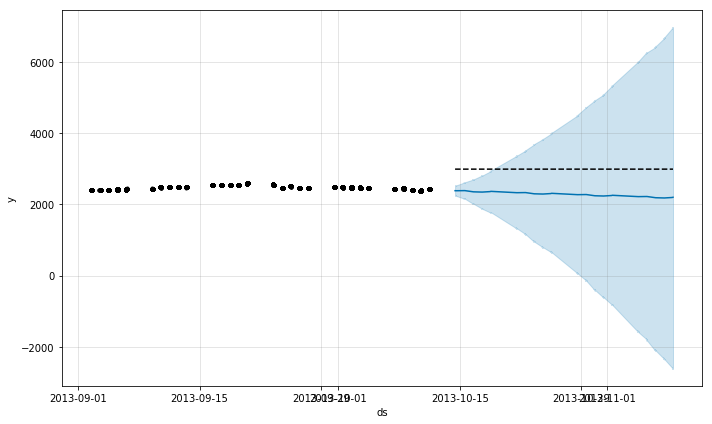

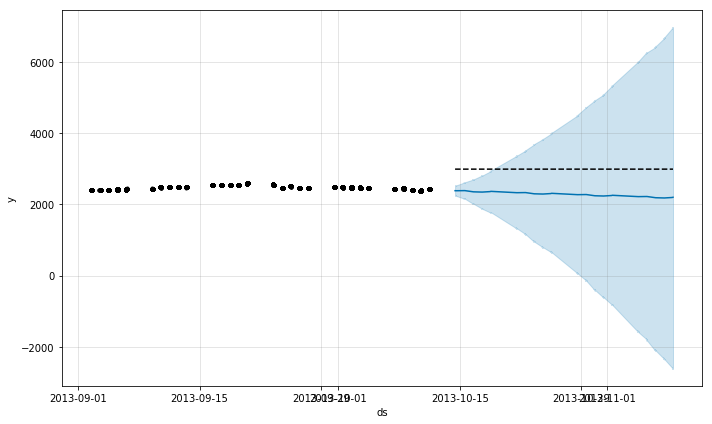

In [34]:
m = prophet_model_constructor()
rnd_stock_name = np.random.choice(adj_prophet_data.stock_name.unique(), 1)[0]
m.fit(adj_prophet_data[adj_prophet_data.stock_name == rnd_stock_name])
example_forecast = m.predict(adj_classifier_data[adj_classifier_data.stock_name\
                                                 == rnd_stock_name])
m.plot(example_forecast)

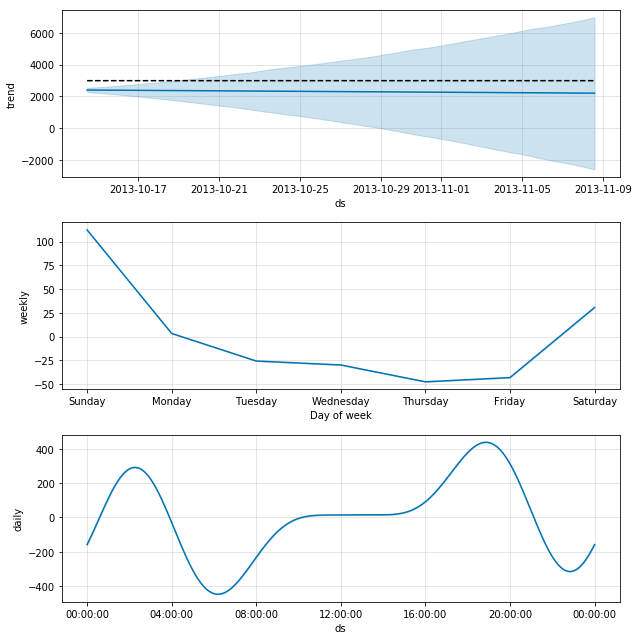

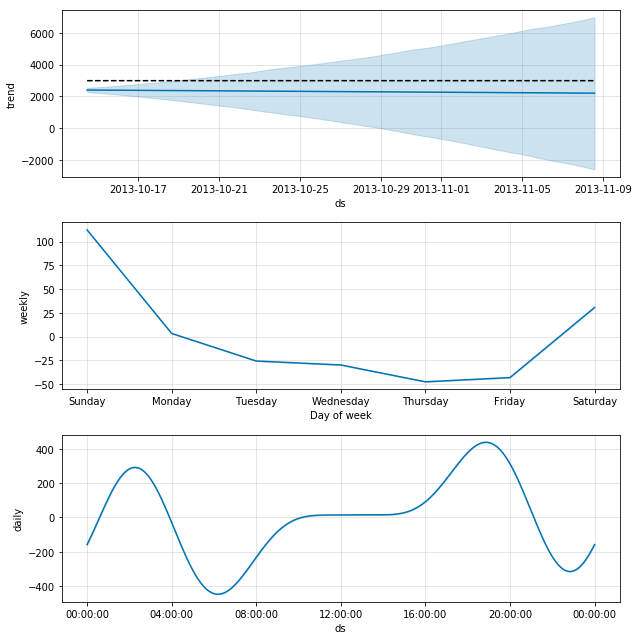

In [36]:
m.plot_components(example_forecast)

In [37]:
# dużo cech

results = construct_and_test_model(train_data=classifier_data,\
                                   test_data=test_data,\
                                   train_forecasts=classifier_train_data_forecasts,\
                                   test_forecasts=classifier_test_data_forecasts,\
                                   train_means=classifier_train_data_means,\
                                   test_means=classifier_test_data_means,\
                                   features=base_features)
results

stock  AUC with prophet  AUC without prophet
0    1243          0.625849             0.623967
1    2645          0.571335             0.569007
2    2822          0.638122             0.636031
3    3107          0.626170             0.631497
4    3388          0.693433             0.690609
5    4154          0.683177             0.683559
6    4481          0.692045             0.695117
7    4549          0.635696             0.638581
8    4575          0.632653             0.634686
9    4799          0.597186             0.589194
10   5836          0.604019             0.601609
11   9065          0.588956             0.587674
12   9067          0.543015             0.538413
13   9086          0.592510             0.594711
14   9094          0.579066             0.579818
15  10470          0.645796             0.642781
16  11399          0.603053             0.610767
17  12327          0.646703             0.644763
18  13113          0.651910             0.652878

In [38]:
results.mean()

stock                  6.543498e+77
AUC with prophet       6.237207e-01
AUC without prophet    6.234560e-01
dtype: float64

In [39]:
# bazowo tylko imbalance

results = construct_and_test_model(train_data=classifier_data,\
                                   test_data=test_data,\
                                   train_forecasts=classifier_train_data_forecasts,\
                                   test_forecasts=classifier_test_data_forecasts,\
                                   train_means=classifier_train_data_means,\
                                   test_means=classifier_test_data_means,\
                                   features=['imbalance'])
results

stock  AUC with prophet  AUC without prophet
0    1243          0.588236             0.600310
1    2645          0.535321             0.544583
2    2822          0.572303             0.576202
3    3107          0.608261             0.582845
4    3388          0.625108             0.611951
5    4154          0.654252             0.651291
6    4481          0.652333             0.667331
7    4549          0.610054             0.589301
8    4575          0.638314             0.634120
9    4799          0.577514             0.570504
10   5836          0.581924             0.560996
11   9065          0.583001             0.585493
12   9067          0.530914             0.528068
13   9086          0.564803             0.569279
14   9094          0.581998             0.596038
15  10470          0.603353             0.603041
16  11399          0.596356             0.580746
17  12327          0.605899             0.614514
18  13113          0.588167             0.639155

In [40]:
results.mean()

stock                  6.543498e+77
AUC with prophet       5.946375e-01
AUC without prophet    5.950404e-01
dtype: float64

In [41]:
# bazowo tylko nieistotna cecha

results = construct_and_test_model(train_data=classifier_data,\
                                   test_data=test_data,\
                                   train_forecasts=classifier_train_data_forecasts,\
                                   test_forecasts=classifier_test_data_forecasts,\
                                   train_means=classifier_train_data_means,\
                                   test_means=classifier_test_data_means,\
                                   features=['mid_price'])
results

stock  AUC with prophet  AUC without prophet
0    1243          0.489961             0.519483
1    2645          0.528437             0.544786
2    2822          0.617195             0.591502
3    3107          0.514684             0.502504
4    3388          0.502724             0.419474
5    4154          0.498710             0.500000
6    4481          0.475356             0.472616
7    4549          0.425792             0.436000
8    4575          0.500940             0.518016
9    4799          0.537506             0.522396
10   5836          0.536615             0.475695
11   9065          0.477637             0.520514
12   9067          0.496517             0.515851
13   9086          0.503352             0.501125
14   9094          0.522143             0.494464
15  10470          0.540180             0.544743
16  11399          0.547971             0.500000
17  12327          0.471857             0.456785
18  13113          0.465596             0.489206

In [42]:
results.mean()

stock                  6.543498e+77
AUC with prophet       5.080619e-01
AUC without prophet    5.013242e-01
dtype: float64